In [1]:
from os import path as osp
import numpy as np
import tensorflow as tf
import sonnet as snt
from attrdict import AttrDict

from evaluation import make_fig, make_logger

from neurocity import minimize_clipped
from neurocity.tools.params import num_trainable_params

from data import load_data, tensors_from_data
from mnist_model import AIRonMNIST

% matplotlib inline

In [2]:
learning_rate = 1e-4
batch_size = 64
img_size = 50, 50
crop_size = 20, 20
n_latent = 50
n_hidden = 256
n_steps = 3

results_dir = '../results'
run_name = 'new_data'

logdir = osp.join(results_dir, run_name)
checkpoint_name = osp.join(logdir, 'model.ckpt')
axes = {'imgs': 0, 'labels': 0, 'nums': 1}

In [3]:
use_prior = True

num_steps_prior = AttrDict(
    anneal='exp',
    init=1. - 1e-7,
    final=1e-5,
    steps_div=1e4,
    steps=1e5
)

appearance_prior = AttrDict(loc=0., scale=1.)
where_scale_prior = AttrDict(loc=.5, scale=1.)
where_shift_prior = AttrDict(scale=1.)

use_reinforce = True
sample_presence = True
step_bias = 1.
transform_var_bias = -3.

init_explore_eps = .00

l2_weight = 0. #1e-5

In [4]:
test_data = load_data('mnist_test.pickle')
train_data = load_data('mnist_train.pickle')

In [5]:
tf.reset_default_graph()
train_tensors = tensors_from_data(train_data, batch_size, axes, shuffle=True)
test_tensors = tensors_from_data(test_data, batch_size, axes, shuffle=False)
x, test_x = train_tensors['imgs'], test_tensors['imgs']
y, test_y = train_tensors['nums'], test_tensors['nums']
    
n_hidden = 32 * 8
n_layers = 2
n_hiddens = [n_hidden] * n_layers
    
air = AIRonMNIST(x, y,
                max_steps=3, 
                explore_eps=init_explore_eps,
                inpt_encoder_hidden=n_hiddens,
                glimpse_encoder_hidden=n_hiddens,
                glimpse_decoder_hidden=n_hiddens,
                transform_estimator_hidden=n_hiddens,
                steps_pred_hidden=[128, 64],
                baseline_hidden=[256, 128],
                transform_var_bias=transform_var_bias,
                step_bias=step_bias)

In [6]:
print num_trainable_params()

1863219


In [7]:
train_step, global_step = air.train_step(learning_rate, l2_weight, appearance_prior, where_scale_prior,
                            where_shift_prior, num_steps_prior)

In [8]:
print num_trainable_params()

2578740


In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
all_summaries = tf.summary.merge_all()

In [10]:
summary_writer = tf.summary.FileWriter(logdir, sess.graph)
saver = tf.train.Saver()

In [11]:
# import os

# restore_dir = '/Users/adam/code/attend_infer_repeat/results/galactus/fixed_test_distrib_exp_5e-2'
# restore_step = 1590000
# restore_path = os.path.join(restore_dir, 'model.ckpt-{}'.format(restore_step))
# saver.restore(sess, restore_path)

In [12]:
imgs = train_data['imgs']
presence_gt = train_data['nums']
train_itr = -1

In [13]:
train_batches = train_data['imgs'].shape[0]
test_batches = test_data['imgs'].shape[0]
log = make_logger(air, sess, summary_writer, train_tensors, train_batches, test_tensors, test_batches)

In [21]:
train_itr = sess.run(global_step)
print 'Starting training at iter = {}'.format(train_itr)

if train_itr == 0:
    log(0)

while train_itr < 1e6:
        
    train_itr, _ = sess.run([global_step, train_step])
    
    if train_itr % 1000 == 0:
        summaries = sess.run(all_summaries)
        summary_writer.add_summary(summaries, train_itr)
        
    if train_itr % 5000 == 0:
        log(train_itr)
        
    if train_itr % 5000 == 0:
#         saver.save(sess, checkpoint_name, global_step=train_itr)
        make_fig(air, sess, logdir, train_itr)    

Starting training at iter = 110144
Step 115000, Data train prior_loss = 64.4808, loss = -557.5152, appearance_prior_loss = 41.0097, where_kl = 12.1579, imp_weight = -13.1694, num_steps_prior_loss = 11.3132, baseline_loss = 22636.5660, reinforce_loss = -1.4406, rec_loss = -621.9959, num_step = 0.9830, num_step_acc = 0.9456, eval time = 20.1s
Step 115000, Data test prior_loss = 79.0699, loss = -527.7494, appearance_prior_loss = 50.0794, where_kl = 15.1355, imp_weight = 16.4266, num_steps_prior_loss = 13.8550, baseline_loss = 22931.3189, reinforce_loss = -0.0911, rec_loss = -606.8193, num_step = 1.2031, num_step_acc = 0.9688, eval time = 0.3563s

Step 120000, Data train prior_loss = 64.7386, loss = -562.1692, appearance_prior_loss = 40.0884, where_kl = 12.9822, imp_weight = 8.4969, num_steps_prior_loss = 11.6680, baseline_loss = 72233.7260, reinforce_loss = -1.4649, rec_loss = -626.9078, num_step = 1.0138, num_step_acc = 0.9210, eval time = 20.13s
Step 120000, Data test prior_loss = 78.38

KeyboardInterrupt: 

In [15]:
# Step 0, Data train prior_loss = 79.7340, loss = -137.9240, appearance_prior_loss = 58.9468, where_kl = 16.7256, imp_weight = -137.9321, num_steps_prior_loss = 4.0616, baseline_loss = 207935.1055, reinforce_loss = 191.8054, rec_loss = -217.6580, num_step = 1.6552, num_step_acc = 0.2030, eval time = 20.52s
# Step 0, Data test prior_loss = 80.3634, loss = -32.3590, appearance_prior_loss = 59.4602, where_kl = 16.8412, imp_weight = -32.3640, num_steps_prior_loss = 4.0620, baseline_loss = 196782.6906, reinforce_loss = 48.3068, rec_loss = -112.7224, num_step = 1.6667, num_step_acc = 0.1823, eval time = 0.4591s

# Step 5000, Data train prior_loss = 56.1600, loss = -538.5864, appearance_prior_loss = 39.5540, where_kl = 15.1861, imp_weight = 9.0004, num_steps_prior_loss = 1.4199, baseline_loss = 30174.7290, reinforce_loss = -8.9212, rec_loss = -594.7464, num_step = 1.3531, num_step_acc = 0.6109, eval time = 21.67s
# Step 5000, Data test prior_loss = 64.6501, loss = -495.0052, appearance_prior_loss = 45.7572, where_kl = 17.4212, imp_weight = 53.3369, num_steps_prior_loss = 1.4716, baseline_loss = 40518.6945, reinforce_loss = -21.7163, rec_loss = -559.6553, num_step = 1.5656, num_step_acc = 0.5135, eval time = 0.3652s

# Step 10000, Data train prior_loss = 58.3092, loss = -558.7546, appearance_prior_loss = 41.7721, where_kl = 15.0125, imp_weight = -13.6546, num_steps_prior_loss = 1.5246, baseline_loss = 21270.5903, reinforce_loss = -15.8663, rec_loss = -617.0638, num_step = 1.1990, num_step_acc = 0.7944, eval time = 21.45s
# Step 10000, Data test prior_loss = 67.6956, loss = -532.0989, appearance_prior_loss = 48.8716, where_kl = 17.1659, imp_weight = 13.0798, num_steps_prior_loss = 1.6581, baseline_loss = 20118.7833, reinforce_loss = -22.8056, rec_loss = -599.7945, num_step = 1.3760, num_step_acc = 0.7625, eval time = 0.3726s

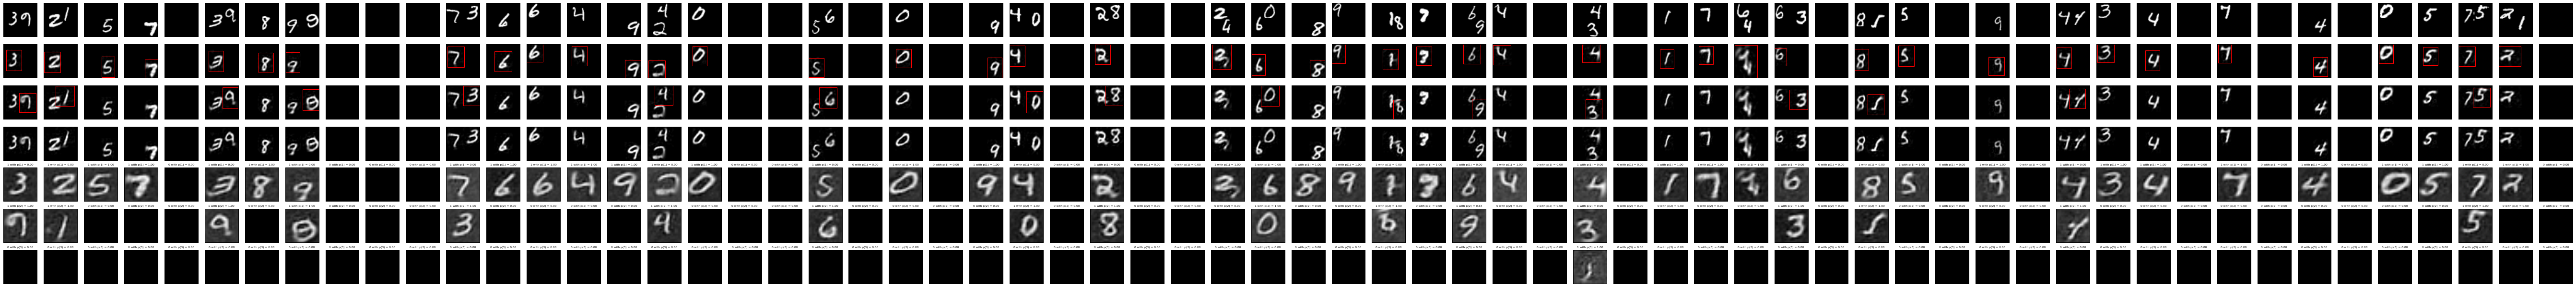

In [20]:
make_fig(air, sess, n_samples=64)

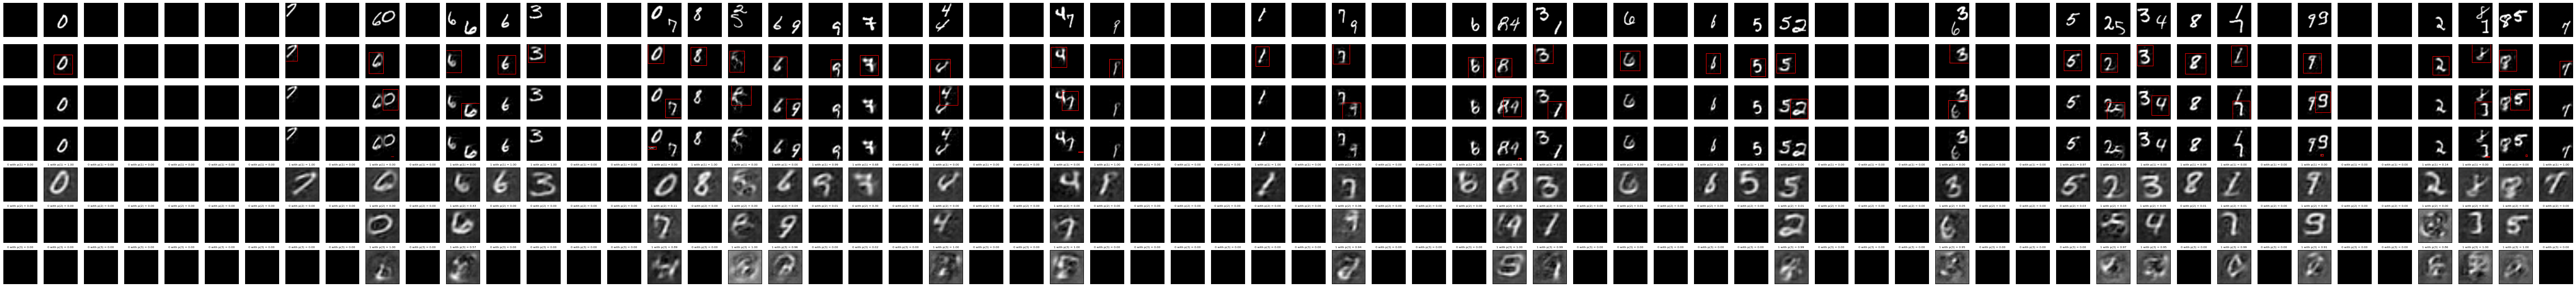

In [18]:
make_fig(air, sess, n_samples=64)